In [9]:
import numpy as np
import matplotlib.pyplot as plt
import freud
import signac
import gsd
import hoomd
import gsd.pygsd
import gsd.hoomd
import scipy
from scipy import signal
import time
import os
from scipy.stats import linregress
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [2]:
data_path = "/home/gwenwhite/cmelab/ptb7-itic/ptb7-project/"
project = signac.get_project(data_path)

In [3]:
state_dict={"size": "small", 
            "process": "quench",
            "kT_reduced":1.8, 
            "density":0.8}

job_list= project.find_jobs(state_dict)
#specify file type
for job in job_list:
    msd_path= job.fn('msd.log')
    rdf_path= job.fn('trajectory.gsd')
    

In [4]:
def atom_type_pos(frame, atom_types): 
    positions = []
    for idx, type_id in enumerate(frame.particles.typeid):
        if frame.particles.types[type_id] in atom_types:
            positions.append(frame.particles.position[idx])
    return positions


def rdf_from_gsd(rdf_path, 
                 atom_types='all', 
                 r_max = None, 
                 r_min= 0.1, 
                 nbins= 50, 
                 start= 95):
    
    try: 
        f = gsd.pygsd.GSDFile(open(rdf_path, "rb"))
    except PermissionError:
        print("problem with", rdf_path)
        return None
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    if r_max is None:
        r_max = max(trajectory[-1].configuration.box[:3]) * 0.45
    freud_rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
    if len(trajectory[start:]) <1: 
        print('two fewer frames')
        return None
    for frame in trajectory[start:-10]:
        if atom_types == 'all':
            freud_rdf.compute(frame, reset=False)
        else:
            query_points = atom_type_pos(frame, atom_types)
            box = frame.configuration.box
            freud_rdf.compute(system=(box, query_points), reset=False)
            
    x = freud_rdf.bin_centers
    y = freud_rdf.rdf
    #Be aware of atom type naming with multiple atom types in function
    filename = job.fn('{}-trajectory-gwen.txt'.format(atom_types[0]))
    np.savetxt(filename, np.transpose([x,y]), delimiter=',', header= "bin_centers, rdf")
    f.close()
    #print("it worked")
    return freud_rdf

def msd_slope(job_list, step_size = 2, atom_types='all'):  
    msd = np.genfromtxt(job_list, names=True, delimiter="\t")
    x = msd['timestep'][-3000::step_size]
    y = msd[atom_types][-3000::step_size]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    plt.plot(x, y, label= "PTB7")
    plt.plot(x, x*slope + intercept, linestyle = 'dotted', label= "slope" )
    plt.title("MSD of PTB7 at %skT %sden" % ( job.sp['kT_reduced'], job.sp['density']))
    plt.xlabel("timestep", fontsize=14)
    plt.ylabel("msd", fontsize=14)
    plt.legend(loc="lower right")
    plt.show()
    #plt.savefig('msd_ptb7_0.6den_0.8kT.pdf')
    return x, y, slope, intercept
    

In [5]:
def msd_analysis(job_list):
    for job in job_list:
        if msd_path:
            x, y, slope, intercept = msd_slope(msd_path)
            

def rdf_analysis(job_list):
    for job in job_list:
        rdf_path= job.fn('trajectory.gsd')
        rdf_from_gsd(rdf_path, atom_types= ['f'], start =0)
        txt_path= job.fn('f-trajectory-gwen.txt')
    line= np.genfromtxt(txt_path, names=True, delimiter=",")
    x= line["bin_centers"]
    y= line["rdf"]
    plt.title("PTB7 fluorine at %skT %sden" % (job.sp['kT_reduced'], job.sp['density']), fontsize=16)
    plt.xlabel("distance r (A.U.)", fontsize=14)
    plt.ylabel("G(r)", fontsize=14)
    plt.plot(x, y)

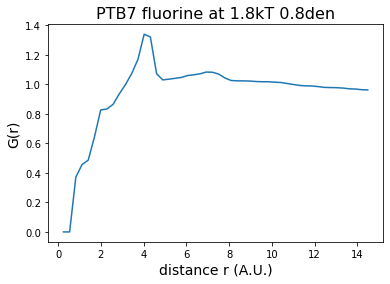

In [6]:
rdf_analysis(job_list)


In [7]:
print(job)

59bded436fe41d8967f5a0247f8bf5c7


### RDF that ignores intra-chain correlations

In [21]:
def snap_bond_graph(snap):
    bond_graph = csr_matrix(
        (np.ones(snap.bonds.N), (snap.bonds.group[:, 0], snap.bonds.group[:, 1])),
        shape=(snap.particles.N, snap.particles.N),
    )
    n_components, labels = connected_components(csgraph=bond_graph, directed=False)
    return labels


def gsd_rdf(
    rdf_path,
    A_name,
    B_name,
    start=0,
    stop=None,
    rmax=None,
    rmin=0,
    bins=50,
    exclude_bonded=True):
    with gsd.hoomd.open(rdf_path) as t:
        snap = t[0]

        if rmax is None:
            rmax = max(snap.configuration.box[:3]) * 0.45

        rdf = freud.density.RDF(bins=bins, r_max=rmax, r_min=rmin)

        if exclude_bonded:
            molecules = snap_bond_graph(snap)

        for snap in t[start:stop]:

            aq = freud.locality.AABBQuery.from_system(snap)
            nlist = aq.query(snap.particles.position, {"r_max": rmax}).toNeighborList()

            type_A = snap.particles.typeid == snap.particles.types.index(A_name)
            if A_name != B_name:
                type_B = snap.particles.typeid == snap.particles.types.index(B_name)
            else:
                type_B = type_A

            nlist.filter(
                np.logical_and(
                    type_A[nlist.query_point_indices], type_B[nlist.point_indices]
                )
            )

            if exclude_bonded:
                nlist.filter(
                    molecules[nlist.query_point_indices]
                    != molecules[nlist.point_indices]
                )

            rdf.compute(aq, neighbors=nlist, reset=False)
        return rdf

In [22]:
gsdfile = rdf_path
A_name = "ss"
B_name = "cc"
bins=50
rmin=0.01
rmax=4
exclude_bonded=True

with gsd.hoomd.open(gsdfile) as t:
    snap = t[0]

    if rmax is None:
        rmax = max(snap.configuration.box[:3]) * 0.45

    rdf = freud.density.RDF(bins=bins, r_max=rmax, r_min=rmin, normalize=False)

    if exclude_bonded:
        molecules = snap_bond_graph(snap)
    
    
    aq = freud.locality.AABBQuery.from_system(snap)
    nlist = aq.query(snap.particles.position, {"r_max": rmax}).toNeighborList()
    
    type_A = snap.particles.typeid == snap.particles.types.index(A_name)
    if A_name != B_name:
        type_B = snap.particles.typeid == snap.particles.types.index(B_name)
    else:
        type_B = type_A
    
    nlist.filter(
        np.logical_and(
            type_A[nlist.query_point_indices], type_B[nlist.point_indices]
        )
    )
    
    if exclude_bonded:
        nlist.filter(
            molecules[nlist.query_point_indices]
            != molecules[nlist.point_indices]
        )
    
    rdf.compute(aq, neighbors=nlist, reset=False)

In [23]:
print(len(nlist.query_point_indices))
print(len(nlist.point_indices))
print(len(nlist.distances))
box = freud.Box(*snap.configuration.box)
print(box)
normalize = len(nlist.distances)/box.volume

224
224
224
freud.box.Box(Lx=162.5894775390625, Ly=162.5894775390625, Lz=162.5894775390625, xy=0.0, xz=0.0, yz=0.0, is2D=False)


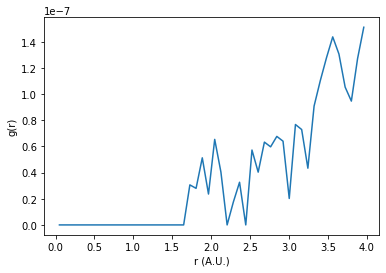

In [24]:
plt.plot(rdf.bin_centers, rdf.rdf*normalize)
plt.xlabel("r (A.U.)")
plt.ylabel("g(r)")
plt.show()